In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression


import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing


from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

# Perameters


In [2]:
cheap_node_list = ['001e063059c2', '001e06305a61', '001e06305a6c', '001e06318cd1',
                   '001e06323a05', '001e06305a57', '001e06305a6b', '001e06318c28',
                   '001e063239e3', '001e06323a12']

cheap_node_id = '001e06305a6b'
node_id = '10004098'
gps_node_id = '001e0610c2e9'
dir_out = '../figures/' + cheap_node_id + '/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

## Read Data

In [3]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + node_id + '_'+ cheap_node_id +'.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')
df = df[(df.index.date != datetime.date(2019, 12, 31)) # Minolta was covered in these dates
       &(df.index.date != datetime.date(2019, 12, 27))
       &(df.index.date != datetime.date(2020,  1,  1))
       &(df.index.date != datetime.date(2020,  1,  2))]
#        &(df.index.date != datetime.date(2020, 2, 14))
#        &(df.index.date != datetime.date(2020, 2, 21))] 

In [8]:
df.columns[:50]

Index(['cloudPecentage', 'allRed', 'allGreen', 'allBlue', 'skyRed', 'skyGreen',
       'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue', 'Violet', 'Blue',
       'Green', 'Yellow', 'Orange', 'Red', 'Temperature', 'Pressure',
       'Humidity', 'Latitude', 'Longitude', 'Altitude', 'NH3', 'CO', 'NO2',
       'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'CO2', 'Luminosity', 'IR',
       'Full', 'Visible', 'Lux', 'UVA', 'UVB', 'Visible Compensation',
       'IR Compensation', 'UV Index', 'Illuminance', '360nm', '361nm', '362nm',
       '363nm', '364nm', '365nm', '366nm', '367nm'],
      dtype='object')

In [4]:
print(df.columns[:41]) # the last is UV Index
print('Variable Numbers in cheap sensors: 41')
print('Sample Numbers: ',len(df))

Index(['cloudPecentage', 'allRed', 'allGreen', 'allBlue', 'skyRed', 'skyGreen',
       'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue', 'Violet', 'Blue',
       'Green', 'Yellow', 'Orange', 'Red', 'Temperature', 'Pressure',
       'Humidity', 'Latitude', 'Longitude', 'Altitude', 'NH3', 'CO', 'NO2',
       'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'CO2', 'Luminosity', 'IR',
       'Full', 'Visible', 'Lux', 'UVA', 'UVB', 'Visible Compensation',
       'IR Compensation', 'UV Index'],
      dtype='object')
Variable Numbers in cheap sensors: 41
Sample Numbers:  296938


In [5]:
features = [#'cloudPecentage', 'allRed', 'allGreen', 'allBlue',
            #'skyRed', 'skyGreen', 'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue',
            'Violet', 'Blue', 'Green', 'Yellow', 'Orange', 'Red',
            'Temperature', 'Pressure', 'Humidity',
            #'Latitude', 'Longitude', 'Altitude',
            #'NH3', 'CO', 'NO2', 'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'CO2',
            'Luminosity', 'IR', 'Full', 'Visible', 'Lux',
            'UVA', 'UVB', 'Visible Compensation','IR Compensation', 'UV Index',
            'Zenith','Azimuth','Sun Distance']
features = np.array(features)
len(features)

20

In [7]:
target = '450nm'
target_name = target # this is for display
X = df[features]
y = df[[target]] # MLP and scaler use multi output

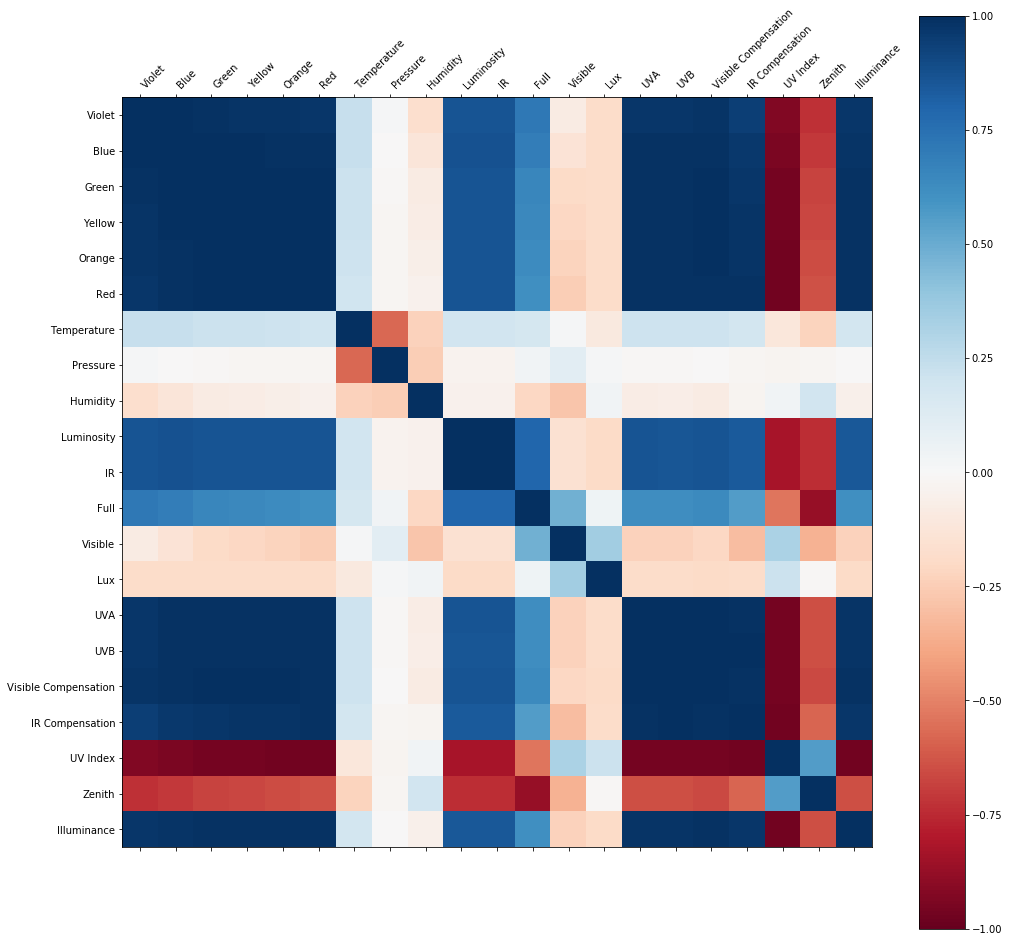

In [8]:
def showCorr(cols):
    size = len(cols)*0.8
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df[cols].corr(), cmap='RdBu')
    cax.set_clim(-1, 1);
    #plt.title('Correlation Matrix\n\n\n')
    fig.colorbar(cax)
    ax.set_xticklabels(np.append([""],cols), rotation=45, ha="left")
    ax.set_yticklabels(np.append([""],cols))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

showCorr(np.append(features, 'Illuminance'))

In [9]:
features_all = ['cloudPecentage', 'allRed', 'allGreen', 'allBlue',
            'skyRed', 'skyGreen', 'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue',
            'Violet', 'Blue', 'Green', 'Yellow', 'Orange', 'Red',
            'Temperature', 'Pressure', 'Humidity',
            'Latitude', 'Longitude', 'Altitude',
            'NH3', 'CO', 'NO2', 'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'CO2',
            'Luminosity', 'IR', 'Full', 'Visible', 'Lux',
            'UVA', 'UVB', 'Visible Compensation','IR Compensation', 'UV Index',
            'Zenith']
features_all = np.array(features_all)
len(features_all)

42

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, df['Illuminance'], test_size=0.9, random_state=0)
MIs = mutual_info_regression(X_train, y_train, n_neighbors=3)

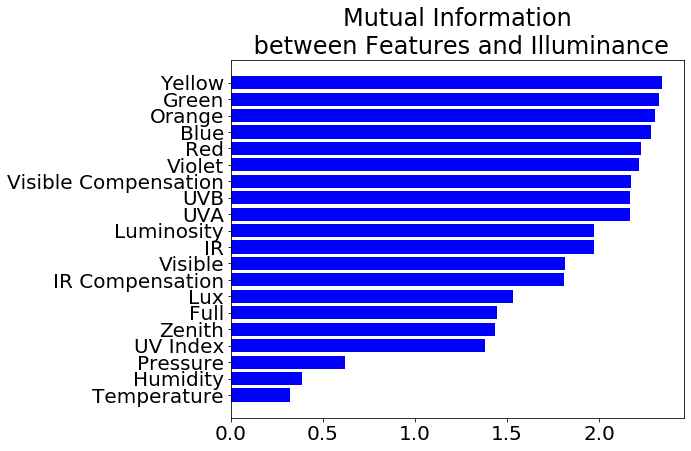

In [43]:
# rank feature inportance
num_features = len(features)
#std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(MIs)[::-1]

var_sorted = features[indices]
MIs_sorted = MIs[indices]

plt.rcParams["figure.figsize"] = (10, num_features/3) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features],
        MIs_sorted[:], color = 'blue',
        #yerr=std[indices][:num_features], ecolor='black',
        align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Mutual Information\n between Features and Illuminance')
plt.tight_layout()
plt.savefig(dir_out + '/Mutual_Information_Illuminance.png')

## Prepare Data  For Training

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# scale the data
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [39]:
n_components = 18

DR = 'PCA'
Cluster = 'None'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_train_scaled_DR = pca.fit_transform(X_train_scaled)
X_test_scaled_DR = pca.transform(X_test_scaled)

print(pca.explained_variance_)


[1.34800963e+01 2.08790813e+00 1.55495757e+00 1.10210674e+00
 8.12184035e-01 4.13857172e-01 2.69673787e-01 1.73131986e-01
 4.84529514e-02 4.22295245e-02 1.42009996e-02 1.10584758e-03
 9.60324112e-05 4.81412873e-05 1.91574834e-05 5.94290405e-06
 5.37566942e-06 4.52938970e-06]


In [1]:
scaler_x2 = StandardScaler()
X_train_scaled_DR_scaled = scaler_x2.fit_transform(X_train_scaled_DR)
X_test_scaled_DR_scaled = scaler_x2.transform(X_test_scaled_DR)

NameError: name 'StandardScaler' is not defined

# Model Start from here

In [24]:
# start_time = time.time()

# hidden_layer_sizes = []
# for i in range(10,500,10):
#     hidden_layer_sizes.append([i])
# activation ='relu'
# solver = 'adam'
# alpha=1e-5 #L2 penalty (regularization term) parameter
# # NN Model, grid search to find best parameter
# regr = MLPRegressor(random_state = RANDOM_STATE,
#                    activation = activation,
#                    solver=solver,
#                    alpha=alpha)

# param_grid = {'hidden_layer_sizes': hidden_layer_sizes}
# CV_regr = GridSearchCV(estimator = regr, param_grid = param_grid, cv =5, verbose = 3)#, n_jobs = n_jobs)

# length_sample = len(X_train_scaled)//10
# CV_regr.fit(X_train_scaled_DR_scaled[:length_sample], y_train_scaled[:length_sample].flatten())
# print(CV_regr.best_params_)
# print(CV_regr.best_score_)

# print("--- %s seconds ---" % (time.time() - start_time))

In [25]:
#hidden_layer_sizes=(32,64,128)
hidden_layer_sizes=(64,128,256)#
#hidden_layer_sizes=(128,128,128,128)
#hidden_layer_sizes=(150)
activation ='relu'
solver = 'adam'
alpha=1e-5 # L2 penalty (regularization term) parameter, default 1e-5
learning_rate = 'constant'

# include layer structure and activation function
structure = '_' + DR + str(n_components) + \
            '_' + str(hidden_layer_sizes)[1:-1].replace(', ','_') + \
            '_' + activation

In [26]:
start_time = time.time()


regr = MLPRegressor(random_state = RANDOM_STATE,
                    hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    alpha = alpha,
                    learning_rate = learning_rate,
                    verbose = True
                    )
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

# fine tune the model
regr.warm_start = True
regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

print("--- %s seconds ---" % (time.time() - start_time))

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.00875612
Iteration 2, loss = 0.00156540
Iteration 3, loss = 0.00130406
Iteration 4, loss = 0.00121333
Iteration 5, loss = 0.00101372
Iteration 6, loss = 0.00094303
Iteration 7, loss = 0.00089962
Iteration 8, loss = 0.00085069
Iteration 9, loss = 0.00078100
Iteration 10, loss = 0.00075716
Iteration 11, loss = 0.00072394
Iteration 12, loss = 0.00067118
Iteration 13, loss = 0.00066891
Iteration 14, loss = 0.00063091
Iteration 15, loss = 0.00061440
Iteration 16, loss = 0.00060201
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 17, loss = 0.00041594
Iteration 18, loss = 0.00039165
Iteration 19, loss = 0.00038212
Iteration 20, loss = 0.00037617
Iteration 21, loss = 0.00036831
Iteration 22, loss = 0.00036154
Iteration 23, loss = 0.00035888
Iteration 24, loss = 0.00035161
Iteration 25, loss = 0.00034747
Iteration 26, loss = 0.00034481
Iteration 27, loss = 0.00034063
Iteration 28, loss = 0.00033574
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 29, loss = 0.00031478
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
--- 165.0231158733368 seconds ---


In [27]:
# save model
dir_model = '../models/' + cheap_node_id + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)
dir_model +=  target + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

fn_model = dir_model + target + structure + '.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [287]:
# dir_model = '../models/' + cheap_node_id + '/' + target + '/'
# fn_model = dir_model + target + structure + '.sav'
# regr = pickle.load(open(fn_model, 'rb'))

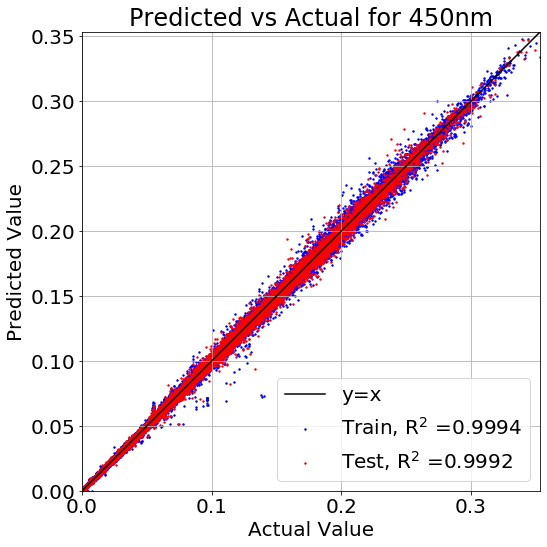

In [28]:
y_train_pred = scaler_y.inverse_transform(\
                    regr.predict( X_train_scaled_DR_scaled ).reshape(-1,1)
                    ) # for train
y_test_pred = scaler_y.inverse_transform(\
                    regr.predict( X_test_scaled_DR_scaled ).reshape(-1,1)
                    ) # for image

train_score =  r2_score(y_train, y_train_pred)
test_score = r2_score(y_test, y_test_pred)

y_min = np.amin(y_train.values)
y_max = np.amax(y_train.values)
y_line = np.linspace(y_min,y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,y_train_pred, s=2, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,y_test_pred, s=2, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((y_min,y_max))
plt.ylim((y_min,y_max))
ax.set_title('Predicted vs Actual for ' + target)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/MLP_performance_'+target+structure+'.png')


In [29]:
# Create object that can calculate shap values
num_shap = 100
explainer = shap.KernelExplainer(regr.predict, X_train_scaled_DR_scaled[:num_shap])
# Calculate shap_values
shap_values = explainer.shap_values(X_train_scaled_DR[:num_shap])
# default l1_reg='auto'(num_features=10)

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


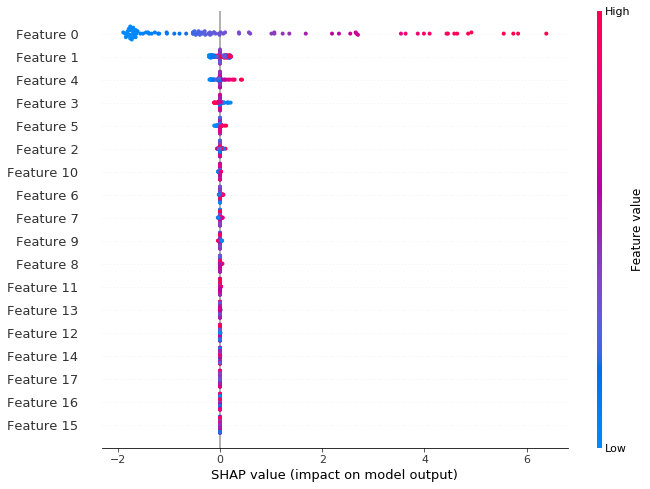

In [30]:
# plot
max_display = n_components
shap.summary_plot(shap_values, X_train_scaled_DR_scaled[:num_shap],
                  plot_size=(10,max_display/2.5),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + target_name + '/MLP_shap_'+ target_name+structure+'.png')

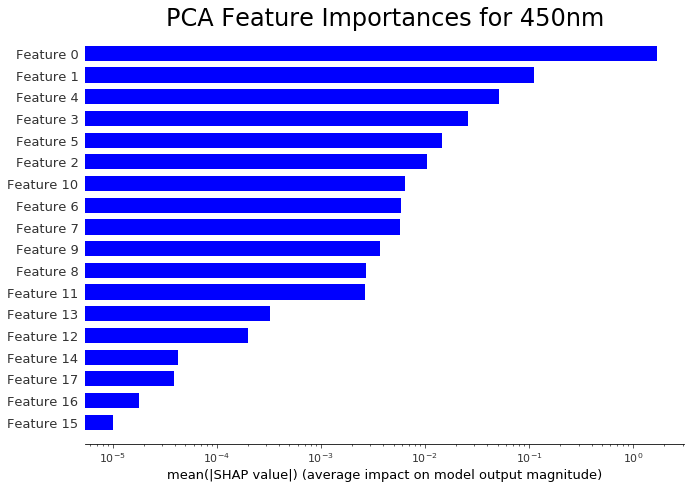

In [31]:
plt.rcParams.update({'font.size': 20})
shap.summary_plot(shap_values, X_train_scaled_DR_scaled[:num_shap],
                  plot_size=(10,max_display/2.5),#'auto'
                  color = 'blue',
                  max_display = max_display,
                  show=False,
                  plot_type = 'bar'
                 )
plt.xscale("log")
plt.title('PCA Feature Importances for ' + target)
plt.tight_layout()
plt.savefig(dir_out + target + '/MLP_PCAImportances_' + target + structure +'.png')

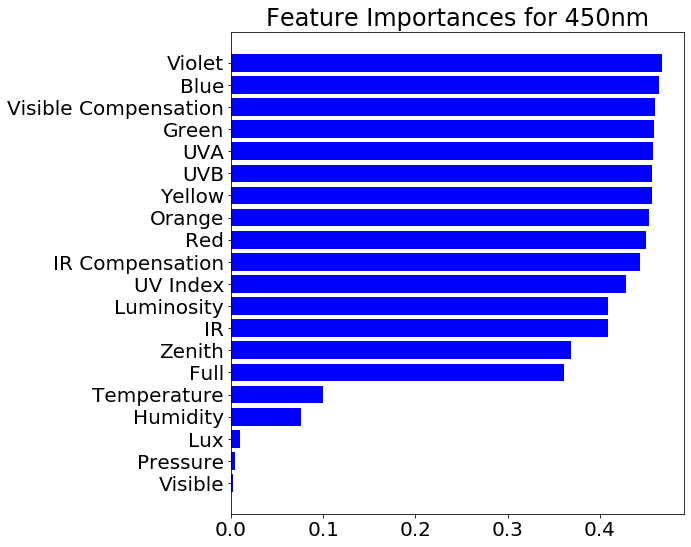

In [32]:
# rank feature inportance
num_features = len(features)
importances_pca = np.mean(np.abs(shap_values), axis = 0)
importances = np.abs(np.dot(importances_pca, pca.components_))
#std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/2.5) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features],
        var_imp_sorted[:num_features], color = 'blue',
        #yerr=std[indices][:num_features], ecolor='black',
        align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances for ' + target_name)
plt.tight_layout()
plt.savefig(dir_out + target_name + '/MLP_Importances_'+ target_name + structure +'.png')

In [ ]:
tar